# DOG BREED CLASSIFICATION USING TRANSFER LEARNING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
import os
import cv2

In [2]:
label_df = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
label_df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


## PREPARING IMAGES AND LABELS

In [3]:
labels = label_df["breed"]
unique_breeds = np.unique(labels)
# ONE HOT ENCODING LABELS
boolean_labels = [label == unique_breeds for label in labels]

# MAKING A LIST OF ALL FILE NAMES
filenames=list("/kaggle/input/dog-breed-identification/train/"+ label_df["id"]+".jpg")

In [48]:
NUM_IMAGES = len(label_df)

# TRAIN TEST SPLIT
x=filenames
y=boolean_labels

from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval=train_test_split(x[:NUM_IMAGES],y[:NUM_IMAGES],
                                         test_size=0.15,random_state=42)
len(xtrain),len(ytrain),len(xval),len(yval)

(8688, 8688, 1534, 1534)

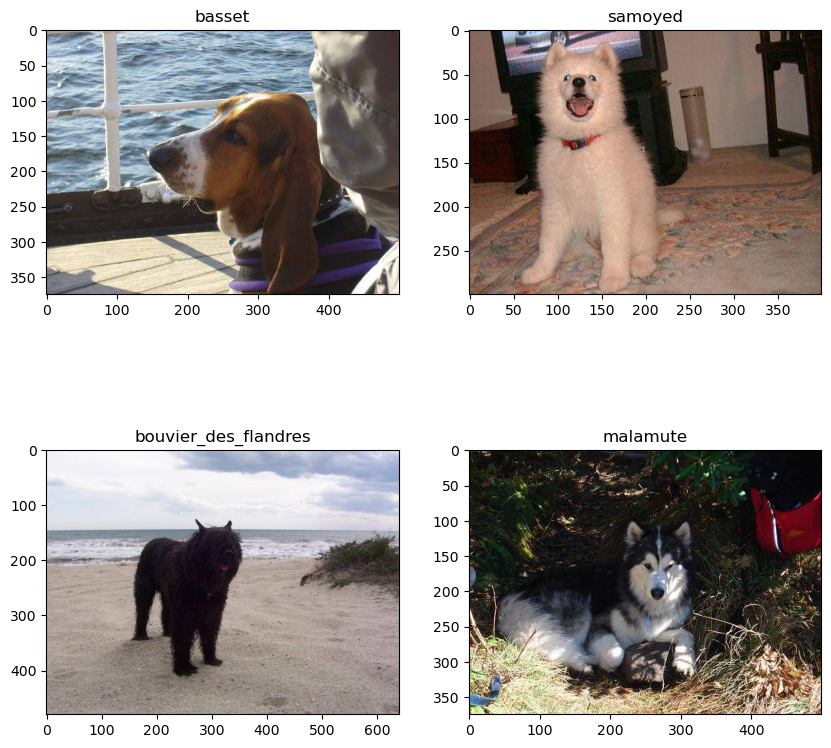

In [72]:
from PIL import Image
fig, ax = plt.subplots(2,2,figsize = (10,10))
for i in range(0,2):
    ax[i][0].imshow(Image.open(xtrain[i]))
    ax[i][0].set_title(f"{unique_breeds[np.argmax(ytrain[i])]}")
    ax[i][1].imshow(Image.open(xtrain[i+3]))
    ax[i][1].set_title(f"{unique_breeds[np.argmax(ytrain[i+3])]}")

In [49]:
IMG_SIZE=224
# A FUNCTION TO PROCESS AN IMAGE AND CONVERT IT INTO A TENSOR
def image_process(image_path):
    #Reading an image
    image=tf.io.read_file(image_path)
    #Turning to tensors
    image=tf.image.decode_jpeg(image,channels=3)
    #Convert the colour value to 0-1
    image=tf.image.convert_image_dtype(image,tf.float32)
    #Resize the image
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
    return image

def get_labels(image_path,label):
    image = image_process(image_path)
    return image,label

In [50]:
# CREATING DATA BATCHES
BATCH_SIZE = 32
def create_data_batches(x,y=None,batch_size = BATCH_SIZE,valid_data = False, test_data = False):
    if test_data:
        print("CREATING TEST BATCHES ...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(image_process).batch(BATCH_SIZE)
        return data_batch

    elif valid_data:
        print("CREATING VALIDATION BATCHES ...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data_batch = data.map(get_labels).batch(BATCH_SIZE)
        return data_batch

    else :
        print("CREATING TRAINING BATCHES ...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        data = data.shuffle(buffer_size = len(x))
        data_batch = data.map(get_labels).batch(BATCH_SIZE)
        return data_batch

In [51]:
train_data = create_data_batches(xtrain,y=ytrain)
valid_data = create_data_batches(xval,y=yval,valid_data=True)

CREATING TRAINING BATCHES ...
CREATING VALIDATION BATCHES ...


In [52]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

## DEFINING MODEL

In [58]:
def create_model(input_shape = INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url = MODEL_URL):
    print("BUILDING MODEL WITH ",MODEL_URL)

    # SETUP MODEL LAYERS
    model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")
    ])

    # COMPILING THE MODEL
    model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
    )

    #BUILD THE MODEL
    model.build(INPUT_SHAPE)
    return model

In [61]:
model = create_model()
model.summary()

BUILDING MODEL WITH  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_5 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## MODEL TRAINING

In [62]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/DogBreedClassifier.h5', verbose=1, save_best_only=True)

results = model.fit(train_data,
                    validation_data = valid_data, 
                    epochs=10,
                    callbacks=checkpointer
                    )

Epoch 1/10
271/272 [============================>.] - ETA: 0s - loss: 1.4730 - accuracy: 0.6429
Epoch 1: val_loss improved from inf to 0.70947, saving model to /kaggle/working/DogBreedClassifier.h5
272/272 [==============================] - 30s 95ms/step - loss: 1.4715 - accuracy: 0.6431 - val_loss: 0.7095 - val_accuracy: 0.7960
Epoch 2/10
271/272 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8781
Epoch 2: val_loss improved from 0.70947 to 0.64546, saving model to /kaggle/working/DogBreedClassifier.h5
272/272 [==============================] - 26s 97ms/step - loss: 0.4212 - accuracy: 0.8781 - val_loss: 0.6455 - val_accuracy: 0.8110
Epoch 3/10
271/272 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9369
Epoch 3: val_loss improved from 0.64546 to 0.64447, saving model to /kaggle/working/DogBreedClassifier.h5
272/272 [==============================] - 24s 89ms/step - loss: 0.2390 - accuracy: 0.9370 - val_loss: 0.6445 - val_accuracy: 0.8142

In [63]:
loaded_model = tf.keras.models.load_model("/kaggle/working/DogBreedClassifier.h5", custom_objects = {"KerasLayer":hub.KerasLayer})
pred = loaded_model.predict(valid_data,verbose =1 )


48/48 [==============================] - 5s 89ms/step


In [64]:
def unbatch(data):
    images =[]
    labels =[]
    for image,label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images,labels

val_images,val_labels = unbatch(valid_data)

## VISUALISING OUR PREDICTIONS


Text(0.5, 1.0, 'TRUE: great_pyrenees, PRED: great_pyrenees')

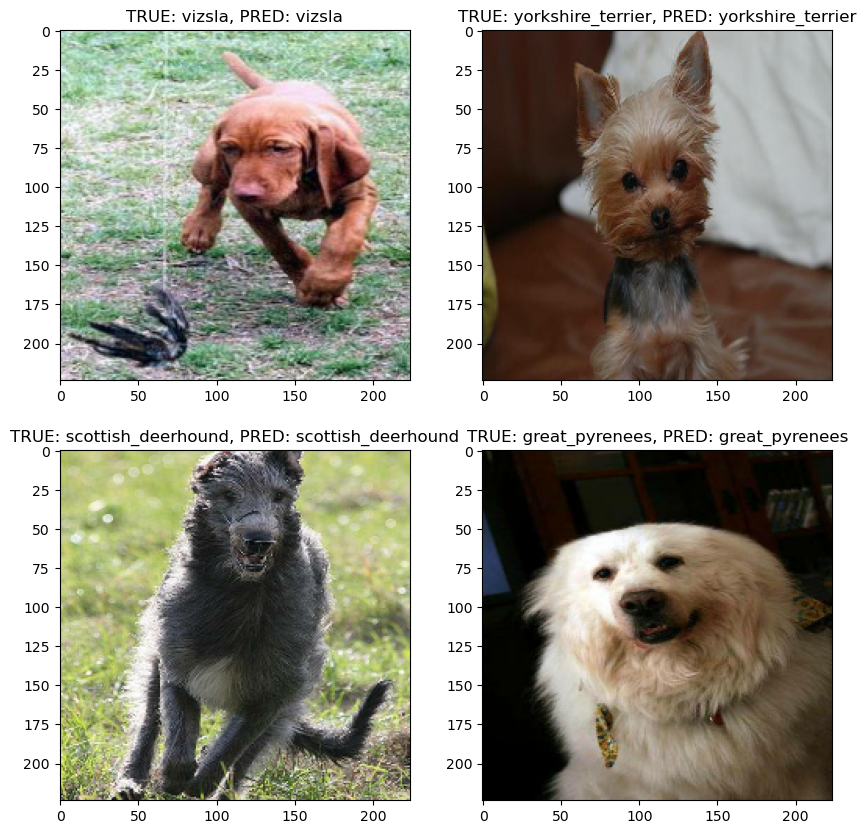

In [66]:
choice = np.random.randint(0,600,4)
fig, ax = plt.subplots(2,2, figsize = (10, 10))
ax[0][0].imshow(val_images[choice[0]])
ax[0][0].set_title(f"TRUE: {unique_breeds[np.argmax(val_labels[choice[0]])]}, PRED: {unique_breeds[np.argmax(pred[choice[0]])]}")
ax[0][1].imshow(val_images[choice[1]])
ax[0][1].set_title(f"TRUE: {unique_breeds[np.argmax(val_labels[choice[1]])]}, PRED: {unique_breeds[np.argmax(pred[choice[1]])]}")

ax[1][0].imshow(val_images[choice[2]])
ax[1][0].set_title(f"TRUE: {unique_breeds[np.argmax(val_labels[choice[2]])]}, PRED: {unique_breeds[np.argmax(pred[choice[2]])]}")
ax[1][1].imshow(val_images[choice[3]])
ax[1][1].set_title(f"TRUE: {unique_breeds[np.argmax(val_labels[choice[3]])]}, PRED: {unique_breeds[np.argmax(pred[choice[3]])]}")